## Background of this notebook

In my previous notebook "Dealing with missing values (Part 1)", the number and types of missingness were analyzed for the combination of train data set and test data set. Based on the analysis results, the imputation was made for 'Fare' and 'Embarked' and the 'Cabin' variable was dropped.

In this notebook, I'll work on the imputation for 'Age'.

## Load packages and modules

### Load libraries, packages and modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
plt.style.use('fivethirtyeight')

### Load the two datasets and combine them

In [2]:
#load train data
#train_df = pd.read_csv('../input/titanic/train.csv')
#test_df = pd.read_csv('../input/titanic/test.csv')
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
#create a new column 'Is_train' to differentiate the training data from the testing data, 1 = training, 0 = testing
train_df['Is_train'] = 1
test_df['Is_train'] = 0
#create the 'Survived' column filled with null values in the testing data
#so as to share the same columns as the training data
test_df['Survived'] = np.nan
#combine the trainning data and testing data
full_df = pd.concat([train_df, test_df], ignore_index=True)
# delete the two dataframes which are no longer needed
del train_df, test_df

### Load the functions

In [3]:
def compare_hists(col_name, bins=None, df=full_df):
    plt.hist(df[df.Survived==1][col_name].dropna(), bins=bins, density=False, label='survived', alpha=0.5)
    plt.hist(df[df.Survived==0][col_name].dropna(), bins=bins, density=False, label='not survived',alpha=0.5)
    plt.title('Histograms of {}'.format(col_name))
    plt.xlabel(col_name)
    plt.ylabel('Number')
    plt.legend(loc='upper right')
    plt.show()

## Prepare data

### Fix some data errors and fill in a couple of missing age values

References:   
[Some SibSp/Parch values are wrong](https://www.kaggle.com/c/titanic/discussion/39787)   
[Miss Erna Alexandra Andersson](https://www.encyclopedia-titanica.org/titanic-survivor/erna-andersson.html)   
[Miss Ida Augusta Margareta Andersson](https://www.encyclopedia-titanica.org/titanic-victim/ida-augusta-margareta-andersson.html)

In [4]:
#fix the errors and fill in the missing age values for the Sammann family
full_df.loc[279, ['SibSp', 'Parch']]= 0, 2
full_df.loc[1283, ['SibSp', 'Parch']] = 1, 1
full_df.loc[987, 'Age'] = 26
full_df.loc[1188, ['Age', 'SibSp', 'Parch']] = 40, 0, 2
full_df.loc[48, ['Age', 'SibSp', 'Parch']] = 16, 1, 1
full_df.loc[920, ['Age', 'SibSp', 'Parch']] = 18, 1, 1
full_df.loc[68, ['SibSp', 'Parch']] = 0, 0
full_df.loc[1105, ['SibSp', 'Parch']] = 0, 0
full_df.loc[736, ['SibSp', 'Parch']] = 0, 4
full_df.loc[[436, 1058, 86, 147], ['SibSp', 'Parch']] = 3, 1

#fix two more errors were found during my deep analysis of fare variable
full_df.loc[[451, 490], 'Fare'] = 6.9667

### Handling the missing values of 'Fare' and 'Embarked' and the 'Cabin'

In [5]:
full_df.loc[1043, 'Fare'] = 7.8292
full_df.loc[[61, 829], 'Embarked'] = 'S'
df = full_df.drop('Cabin', axis=1)
del full_df

## Impute 'Age'

### Review how survival rates vary with age

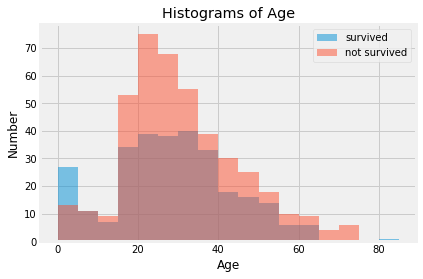

In [6]:
compare_hists('Age', bins=np.arange(0, 90, 5))

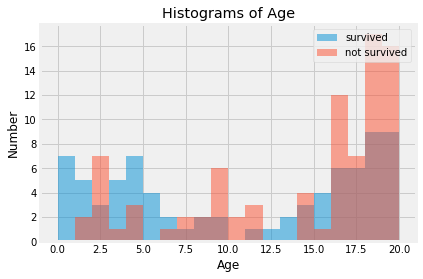

In [7]:
compare_hists('Age', bins=np.arange(21), df=df[df.Age<20])

**Finding:**  
The passengers under 15 (esp under 5) had much higher survival rates than the rest.  
Very few passengers over 65 survived.

## Imputation strategy

### Impute with the median of all the samples?

In [8]:
#the median of all the samples
df.Age.median()

28.0

With the imputation with this median, a boy who had a high chance of survival may be categorized as a man who had a low chance of survival. This imputation strategy is not good.

### Impute with the median of the samples of each Pclass?

In my notebook "titanic-eda-with-detailed-explanation", Pclass has the highest coorelation with Age than the rest features.

In [9]:
#the median values of the samples of three Pclasses
df.groupby('Pclass').Age.median()

Pclass
1    38.5
2    29.0
3    24.0
Name: Age, dtype: float64

This imputation strategy is not good either for the same reason as the last strategy.

### Impute with the median of the samples of each Title?

In [10]:
#extract titles from Nmae
df['Title'] = df['Name'].str.extract('([A-Za-z]+)\.', expand=False)
#check for missing value(s)
df.Title.isnull().sum()

0

In [11]:
#check the counts of each titles
title_counts = df.Title.value_counts()

title_counts.to_frame().T

,Mr,Miss,Mrs,Master,Dr,Rev,Col,Mlle,Ms,Major,Capt,Jonkheer,Lady,Don,Mme,Sir,Dona,Countess
Title,757,260,197,61,8,8,4,2,2,2,1,1,1,1,1,1,1,1


In [12]:
#check the sex of the passengers with different titles in the full dataset
female_titles = set()
male_titles = set()
for t in df.Title.unique():
    if ((df.Title== t) & (df.Sex=='female')).any():
        female_titles.add(t)
    if ((df.Title== t) & (df.Sex=='male')).any():
        male_titles.add(t)

mix_titles = female_titles & male_titles
female_only_titles = female_titles - mix_titles
male_only_titles = male_titles - mix_titles
print('mix_titles:', mix_titles)
print('female_only_titles', female_only_titles)
print('male_only_titles', male_only_titles)

mix_titles: {'Dr'}
female_only_titles {'Mme', 'Countess', 'Miss', 'Dona', 'Ms', 'Lady', 'Mlle', 'Mrs'}
male_only_titles {'Sir', 'Jonkheer', 'Capt', 'Rev', 'Mr', 'Master', 'Col', 'Major', 'Don'}


**Categorize title by count and sex**

|Sex\Counts|>10|<10|
|:--|:--|:--|
|Male|'Mr', 'Master'|'Major', 'Sir', 'Don', 'Capt', 'Jonkheer', 'Rev', 'Col'|
|Female|'Miss', 'Mrs'|'Ms', 'Lady', 'Countess', 'Mme', 'Mlle', 'Dona'|
|Mix||'Dr'|

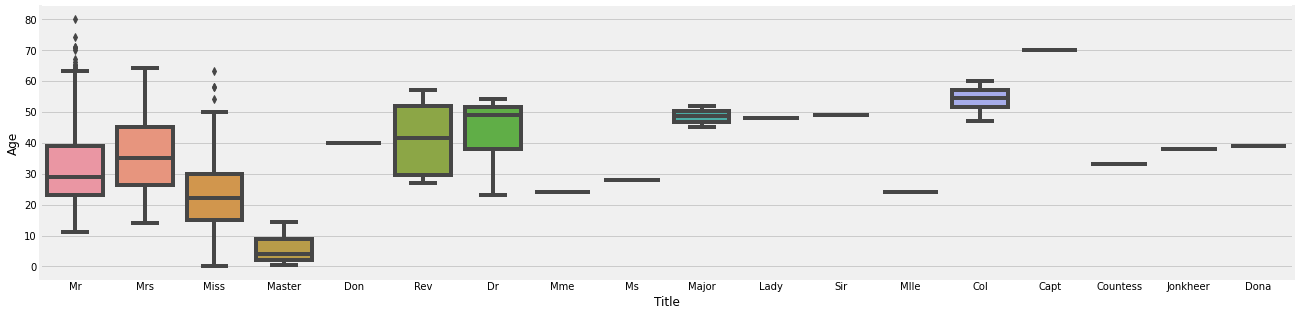

In [13]:
#check the Age ranges of different titles of the full data
plt.figure(figsize=(20,5))
sns.boxplot(x='Title', y='Age', data=df);

In [14]:
#change the title from 'Dr' to 'Dr (female)' for the female
df.loc[(df.Title=='Dr') & (df.Sex == 'female'), 'Title'] = 'Dr (female)'

In [15]:
#group the titles to combine as many rare titles with the common ones as possible
#based on the title definitions and the sex information of the dataset
#rare titles are those in less than 10 samples
title_groups = {'Male adult': ['Mr', 'Don', 'Rev', 'Dr',  'Sir', 'Major',  'Col', 'Capt', 'Countess', 'Jonkheer'],
                'Boy': ['Master'],
                'Miss': ['Miss'],
               'Other female': ['Mrs', 'Dona', 'Mme', 'Mlle', 'Ms', 'Lady', 'Dr (female)']}

In [16]:
df['Title_group'] = df['Title']
for k in title_groups:
    df['Title_group'].replace(title_groups[k], k, inplace=True)

In [17]:
df['Title_group'].value_counts()

Male adult      783
Miss            260
Other female    205
Boy              61
Name: Title_group, dtype: int64

In [18]:
pd.pivot_table(df, values='Age', index='Pclass', columns='Title_group', aggfunc='median')

Title_group,Boy,Male adult,Miss,Other female
Pclass,,,,
1,6.0,42.0,30.0,45.0
2,2.0,30.0,20.0,30.0
3,6.0,26.0,18.0,31.0


In [19]:
pd.pivot_table(df, values='Age', index='Pclass', columns='Title_group', aggfunc='count')

Title_group,Boy,Male adult,Miss,Other female
Pclass,,,,
1,5,147,59,73
2,11,147,48,55
3,37,315,103,49


Imputation strategy:   
The male with 'Master' title are boys while the male with the other titles are adults.   
The median age value of the same title group increases with the drecreasing Pclass value in most cases.
So imputation with the median values of the subsets by 'Title_group'('Title') and Pclass is better than the previous two.   
Due to the small sample size of 'Boy' group and close median values, their imputation is made with the median value of all the samples in that title group.

In [21]:
#median age for boys
boy_median_age = df.loc[df.Title_group == 'Boy', 'Age'].median()
#fillna for boys' age
df.loc[df.Title_group=='Boy', 'Age'] = df.loc[df.Title_group=='Boy', 'Age'].fillna(boy_median_age)
#check the number of missing age values for boys
df.loc[df.Title_group == 'Boy', 'Age'].isnull().sum()

In [39]:
#filling missing age values for other title groups in different pclasses
df['Age'] = df[['Pclass', 'Title_group', 'Age']].\
            groupby(by=['Pclass', 'Title_group']).transform(lambda x: x.fillna(x.median()))

In [40]:
#check the number of missing age values
df['Age'].isnull().sum()

0

## Table of Contents
1. Background of this notebook
2. Load packages and modules   
    2.1 Load libraries, packages and modules   
    2.2 Load the two datasets and combine them   
    2.3 Load the functions   
3. Prepare data   
    3.1 Fix some data errors and fill in a couple of missing age values   
    3.2  Handling the missing values of 'Fare' and 'Embarked' and the 'Cabin'   
4. Impute 'Age'   
    4.1 Review how survival rates vary with age
5. Imputation strategy   
    5.1 Impute with the median of all the samples?   
    5.2 Impute with the median of the samples of each Pclass?   
    5.3 Impute with the median of the samples of each Title?